In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from etransportmodel.trip_data import TripData
from etransportmodel.charging_choice import ChargingChoice
from etransportmodel.charging_demand import ChargingDemand
from etransportmodel.charging_placement import ChargingPlacement
from etransportmodel.optimization_solvers import OptimizationSolvers

c:\Users\Richard Lin\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This file contains an example case study and application of the etransportmodel package. The study are and trip data is the Atlanta metropolitan area, including 21 counties and home to 6 million people in 2020. The region is divided into 951 areas, also named traffic analytic zones, which are geographic units defined by census tracts, and we are searching for the optimal placement of electric vehicle charging infrastructure in each area.

The simulation process is as follows. The market setting and number of chargers in each area are taken as input for charging demand simulation. In the demand simulation, each individual charging choice is simulated in a time sequence. The charging demand and charger occupancy of that choice are recorded, which would affect the charging choice for the following trips and the charger availibility of the incoming users. The REMBO process iteratively runs the demand simulation until the model converges. 

Defining Trip Data Paremeters

In [2]:
### Define Parameters

# Shapefile Path
shapefile = "example_data/Model_Traffic_Analysis_Zones_2020.shp"

# Tripfile Path
tripfile = 'example_data/EV_trip.p'

# Define EV battery capacity & energy rate by distribution define possible energy of EV kWh
# Reference: Tesla (60-100kWh); Nissan Leaf (40-60kWh)
en = {0:60, 1:100, 2:100}

# Define energy consumption rate: kWh/mile 
# Reference: Tesla (0.33-0.38kwh/mi); Audi (0.43kWh/mi)
cn = {0:0.3, 1:0.3, 2:0.35}

# Define probability distriburion of each EN value
prob_en = [0.3,0.6,0.1]

# List of vechile types used in the dictionary
snr = [0,1,2]

# Define charging behavior 
# ('base', 'low_risk_sensitive', 'high_risk_sensitive', 'prefer_fast_charge', 'dislike_fast_charge') 
charge_behave = 'dislike_fast_charge'

# Charger Type
rate_name= ['h2','l2','DCFC'] 

# Location Code Name
location_name = ['home','work','public']

# Charging Rate in KWh
rate = [3.6, 6.2, 150]

# Simulate D days, D > 1
simulated_days = 2

# Home Charging Price in $/kWh
home_price = 0.13

# Public Charging Price in $/kWh
pub_price = 0.43

# Charging available - [home, non-home L2, non_home DCFC]
L_available = [0,1,1]

# Define zone name: the zone ID from geo data
zzones = 'SD10'

# Define life-cycle time in years
year = 10

# Discount Rate
discount_rate = 0.05

# Number of Days in Year
scale_to_year = 365

# Efficiency of Public Charging Station
station_efficiency = 0.95

# Electricity Cost of public charging station in $/kWh
electricity_cost = 0.11

# Types of Chargers are split into home, L2, and DCFC. Below are the build cost and buy cost of each station

# L2 Charger Buy Cost in $
L2_buy_cost = 3450

# L2 Charger Build Cost in $
L2_build_cost = 3000

# DCFC Charger Buy Cost in $
DCFC_buy_cost = 25000

# DCFC Charger Build Cost in $
DCFC_build_cost = 21000

Building a new TripData object containing all the information about the simulation

In [3]:
newTrip = TripData(
    shapefile=shapefile,
    tripfile=tripfile,
    en=en,
    cn=cn,
    prob_en=prob_en,
    snr=snr,
    charge_behave=charge_behave,
    rate=rate,
    location_name=location_name,
    home_price=home_price,
    simulated_days=simulated_days,
    L_available=L_available,
    pub_price=pub_price,
    zzones=zzones,
    year=year,
    discount_rate=discount_rate,
    scale_to_year=scale_to_year,
    station_efficiency=station_efficiency,
    electricity_cost=electricity_cost,
    L2_buy_cost=L2_buy_cost,
    L2_build_cost=L2_build_cost,
    DCFC_buy_cost=DCFC_buy_cost,
    DCFC_build_cost=DCFC_build_cost,
)


In [4]:
newTrip.summary()

*** Trip Chain Information ***
number of EV: 4944
number of trips: 18666
en: {0: 60, 1: 100, 2: 100}
prob_en: [0.3, 0.6, 0.1]
snr: [0, 1, 2]
rate: [3.6, 6.2, 150]
rate_name: ['h2', 'l2', 'l3']
location_name: ['home', 'work', 'public']
*** Charging Demand Parameters ***
home_price: 0.13
simulated days: 2
L_available: [0, 1, 1]
pub_price: 0.43
zzone: SD10
num_zzone: 79
*** Charging Preference Parameters ***
charging behavior: dislike_fast_charge
beta_SOC: 3
beta_R: -0.005
beta_delta_SOC: 2
beta_0: 1
beta_SOC_0: 0.3
beta_cost: 0.1
lambda: 1
*** Charging Placement Parameters ***
year: 10
discount_rate: 0.05
station efficiency: 0.95
electricity cost: 0.11
L2_buy_cost: 3450
L2_build_cost: 3000
DCFC_buy_cost: 25000
DCFC_build_cost: 21000


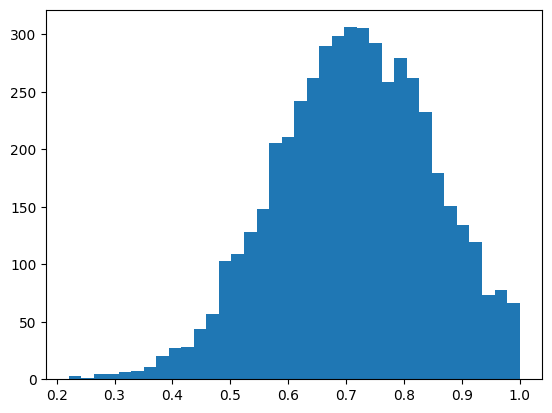

In [5]:
ax = plt.hist(newTrip.SOC_int_, bins='auto')

In [6]:
print('number of EV', len(newTrip.ev_sample))
print('number of trips', len(newTrip.ev_trip))
print('number of zones', newTrip.num_zone)

number of EV 4944
number of trips 18666
number of zones 79


Building Charging Choice Model with exisiting trip data

In [7]:
choiceModel = ChargingChoice(newTrip)

In [8]:
print('charging rate (kW) [home L2, non_home L2, non_home DCFC]:', choiceModel.trip.rate)
print('home charging price ($):', choiceModel.trip.home_price)
print('simulation day:', choiceModel.trip.simulated_days)

charging rate (kW) [home L2, non_home L2, non_home DCFC]: [3.6, 6.2, 150]
home charging price ($): 0.13
simulation day: 2


total energy of EV (kWh): 60


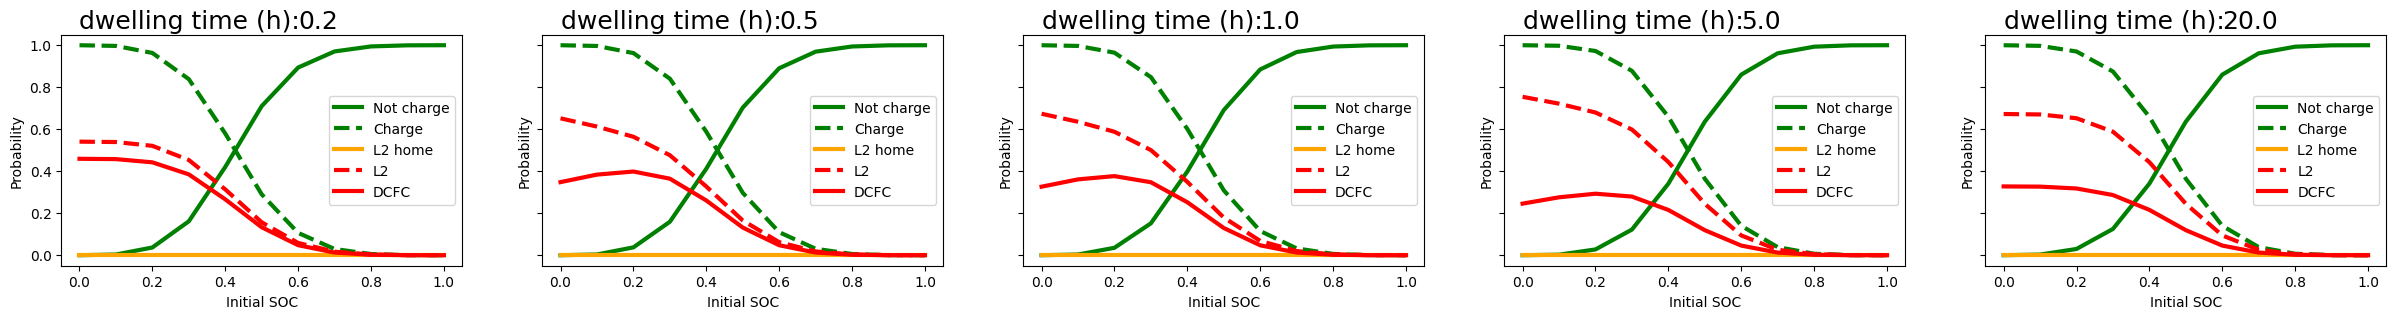

In [9]:
test_En = 60
print('total energy of EV (kWh):', test_En)

wait_time = np.array([0.2,0.5,1,5,20])

fig, axs = plt.subplots(1,len(wait_time), figsize=(6*len(wait_time),3), sharey=True)

SOC_test = np.arange(0, 1.1, 0.1)

for j in range(len(wait_time)):
    z = []
    
    for i in SOC_test:
        z = z + [choiceModel.charging_choice(i,wait_time[j],test_En,L_available,pub_price)[1]]  

    z0 = np.array(z).T[0]
    z1 = np.array(z).T[1]
    z2 = np.array(z).T[2]
    z3 = np.array(z).T[3]
    
    axs[j].plot( SOC_test, z0, marker='', color='green', linewidth=3,linestyle='solid',label="Not charge")
    axs[j].plot( SOC_test, 1-z0, marker='', color='green', linewidth=3, linestyle='dashed',label="Charge")
    axs[j].plot( SOC_test, z1, marker='', color='orange', linewidth=3,linestyle='solid',label="L2 home")
    axs[j].plot( SOC_test, z2, marker='', color='r', linewidth=3,linestyle='dashed',label="L2")
    axs[j].plot( SOC_test, z3, marker='', color='r', linewidth=3,linestyle='solid',label="DCFC")
    axs[j].set_xlabel('Initial SOC')
    axs[j].set_ylabel('Probability')
    axs[j].text(0, 1.08, 'dwelling time (h):', fontsize=18)
    axs[j].text(0.6, 1.08, wait_time[j], fontsize=18)
    axs[j].legend(loc = 'right')

plt.subplots_adjust(hspace=0.3)

total energy of EV (kWh): 100


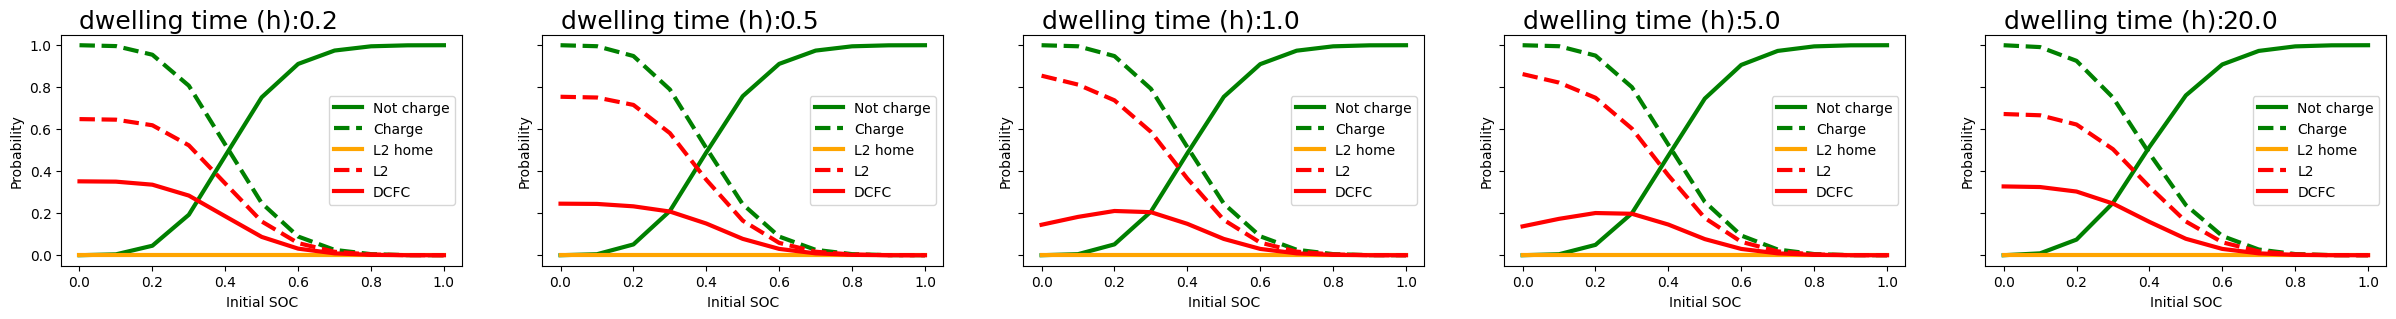

In [10]:
test_En = 100
print('total energy of EV (kWh):',test_En)

import matplotlib.pyplot as plt

wait_time = np.array([0.2,0.5,1,5,20]) #([0.2,0.5,1,2,3,5,6,7,10])

fig, axs = plt.subplots(1,len(wait_time), figsize=(6*len(wait_time),3), sharey=True)

SOC_test = np.arange(0, 1.1, 0.1)

for j in range(len(wait_time)):
    z = []
    
    for i in SOC_test:
        z = z + [choiceModel.charging_choice(i,wait_time[j],test_En,L_available,pub_price)[1]]  

    z0 = np.array(z).T[0]
    z1 = np.array(z).T[1]
    z2 = np.array(z).T[2]
    z3 = np.array(z).T[3]
    
    axs[j].plot( SOC_test, z0, marker='', color='green', linewidth=3,linestyle='solid',label="Not charge")
    axs[j].plot( SOC_test, 1-z0, marker='', color='green', linewidth=3, linestyle='dashed',label="Charge")
    axs[j].plot( SOC_test, z1, marker='', color='orange', linewidth=3,linestyle='solid',label="L2 home")
    axs[j].plot( SOC_test, z2, marker='', color='r', linewidth=3,linestyle='dashed',label="L2")
    axs[j].plot( SOC_test, z3, marker='', color='r', linewidth=3,linestyle='solid',label="DCFC")
    axs[j].set_xlabel('Initial SOC')
    axs[j].set_ylabel('Probability')
    axs[j].text(0, 1.08, 'dwelling time (h):', fontsize=18)
    axs[j].text(0.6, 1.08, wait_time[j], fontsize=18)
    axs[j].legend(loc = 'right')

plt.subplots_adjust(hspace=0.3)

Building Charging Demand Model with exisitng trip data

In [11]:
demandModel = ChargingDemand(newTrip)

Building Charging Placement Model with exisiting trip data

In [12]:
placementModel = ChargingPlacement(newTrip)

Define how to run the simulation and build solver model

In [13]:
# Intial points, needs to be >= 2
N_initial = 2

# New sample points, can't be over 1
BATCH_SIZE = 1

# Number of iterations in each trial
N_BATCH = 5 

# Number of trials run (entire algorithm)
N_TRIALS = 2 

# Define embedding dimension
low_dim = 5

# Define embedding space searching box bounds
x_l_bound = -1
x_u_bound = 1

# Y Variance
y_variance = 0.1

# Maximum number of stations allowed at each location
max_station_capacity = 5

In [14]:
optimizationSolverModel = OptimizationSolvers(
    newTrip,
    low_dim=low_dim, 
    x_l_bound=x_l_bound, 
    x_u_bound=x_u_bound, 
    y_variance=y_variance,
    max_station_capacity=max_station_capacity
)

In [15]:
new_shape = newTrip.shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()


Trial  1 of 2 

C:\Users\Richard Lin\OneDrive - Cornell University\Documents\Cornell University\Spring 24\MEng Project\Etransportation_models\src\etransportmodel\optimization_solvers.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.FloatTensor(rand_yy).to(self.trip.ddtype)



Trial  2 of 2 

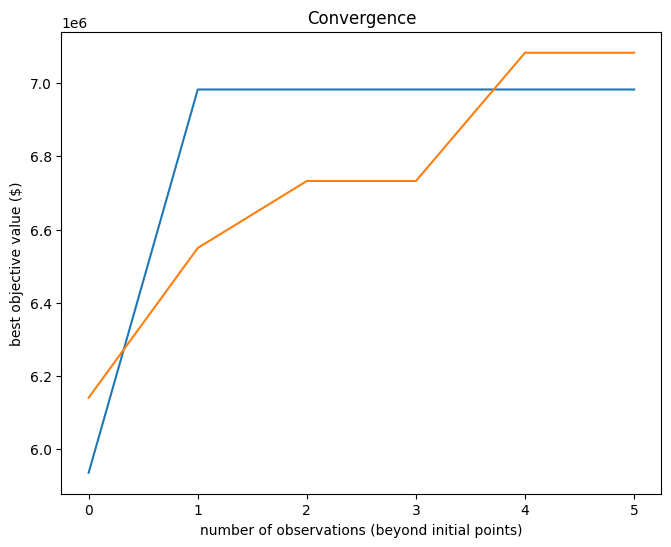

In [16]:
Run_result = optimizationSolverModel.BO_run(N_initial, BATCH_SIZE, N_BATCH, N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y = Run_result

iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])

plt.title('Convergence')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')
plt.subplots_adjust(left=0.15)
plt.show()

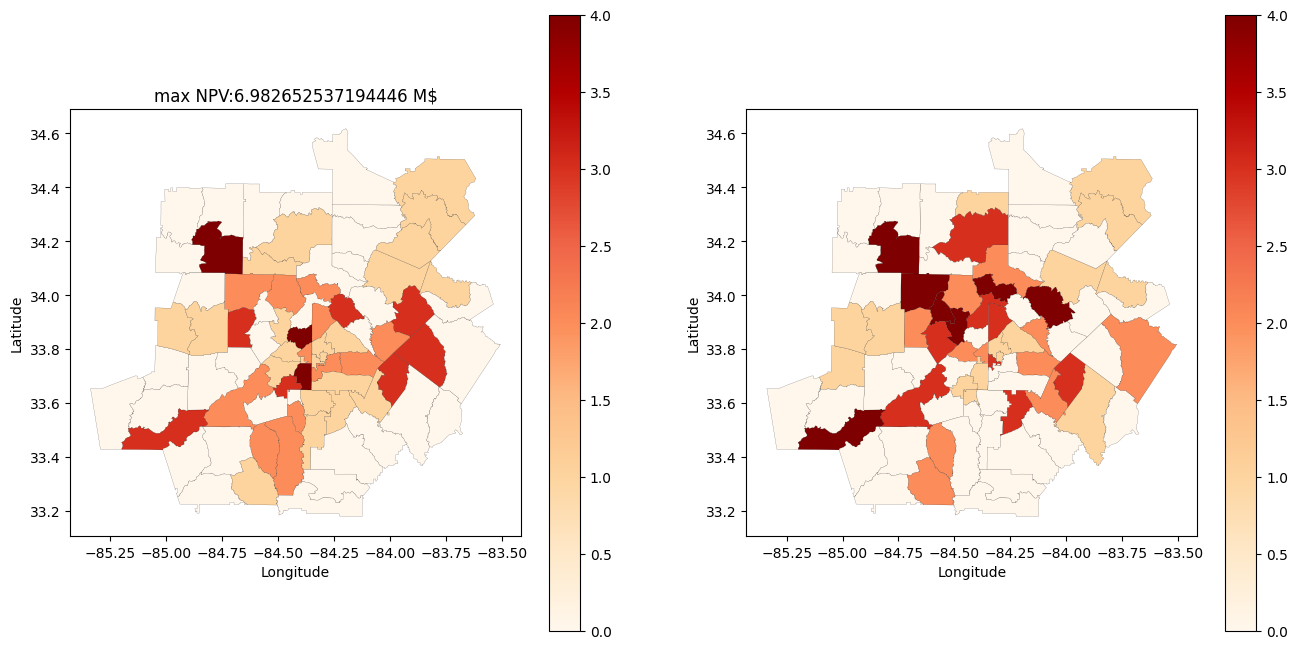

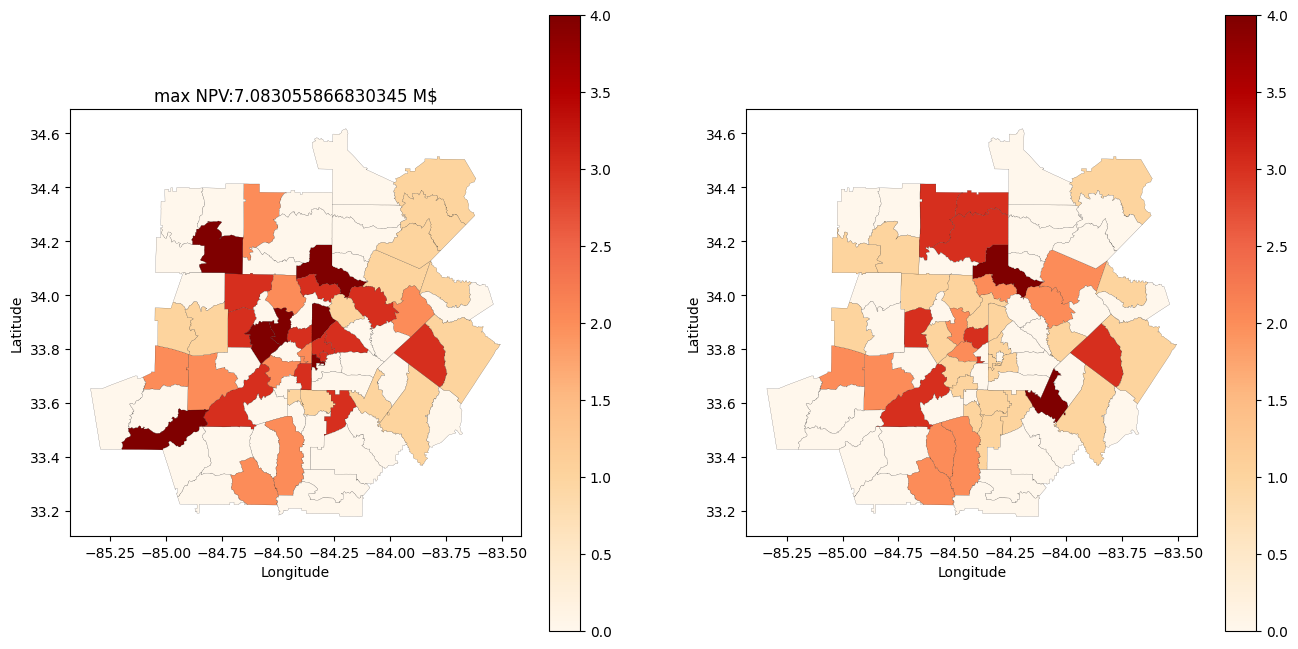

In [17]:
############# plot for BO (run only if used BO solver)

for i in range(len(best_observed_all)):
    which_trial = i
    result_x = best_observed_all_x[which_trial][N_BATCH]
    result_x = torch.reshape(result_x,(2,optimizationSolverModel.trip.num_zone)).to(dtype = optimizationSolverModel.trip.ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')



Trial  1 of 2 .....
Trial  2 of 2 .....

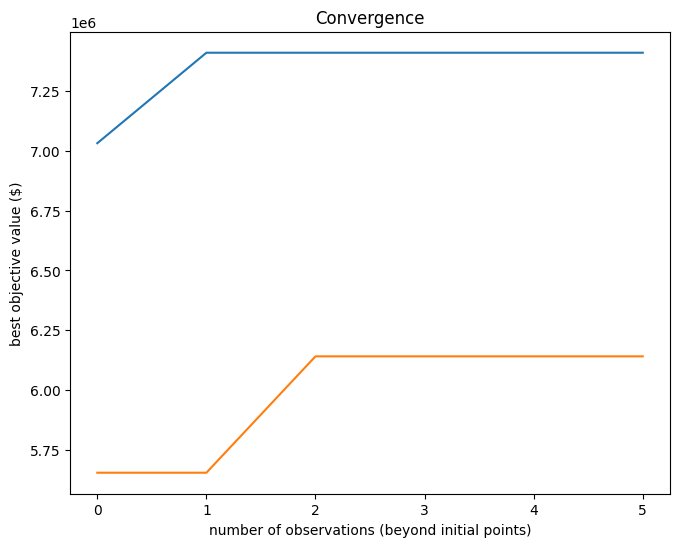

In [18]:
Run_result = optimizationSolverModel.Random_search(N_BATCH,N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y = Run_result

iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])

plt.title('Convergence')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')
plt.subplots_adjust(left=0.15)
plt.show()


Trial  1 of 2 
Trial  2 of 2 

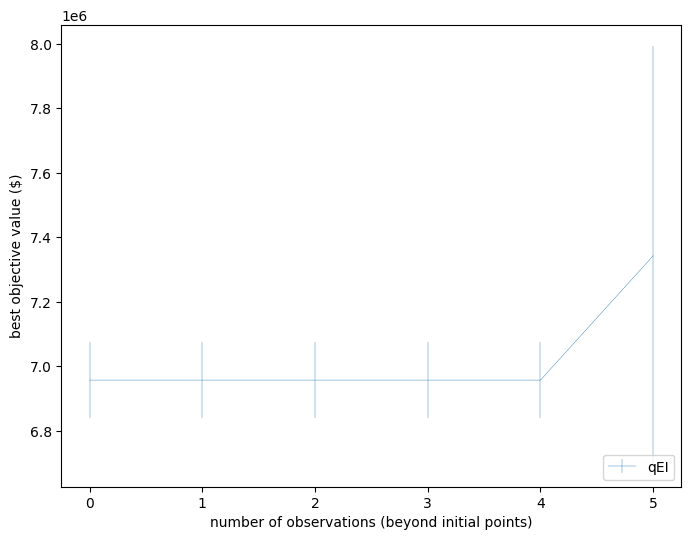

In [19]:
Run_result = optimizationSolverModel.REMBO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y, A_all = Run_result

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

iters = np.arange(len(best_observed_all_x[0]))
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=0.3)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
ax.legend(loc="lower right")



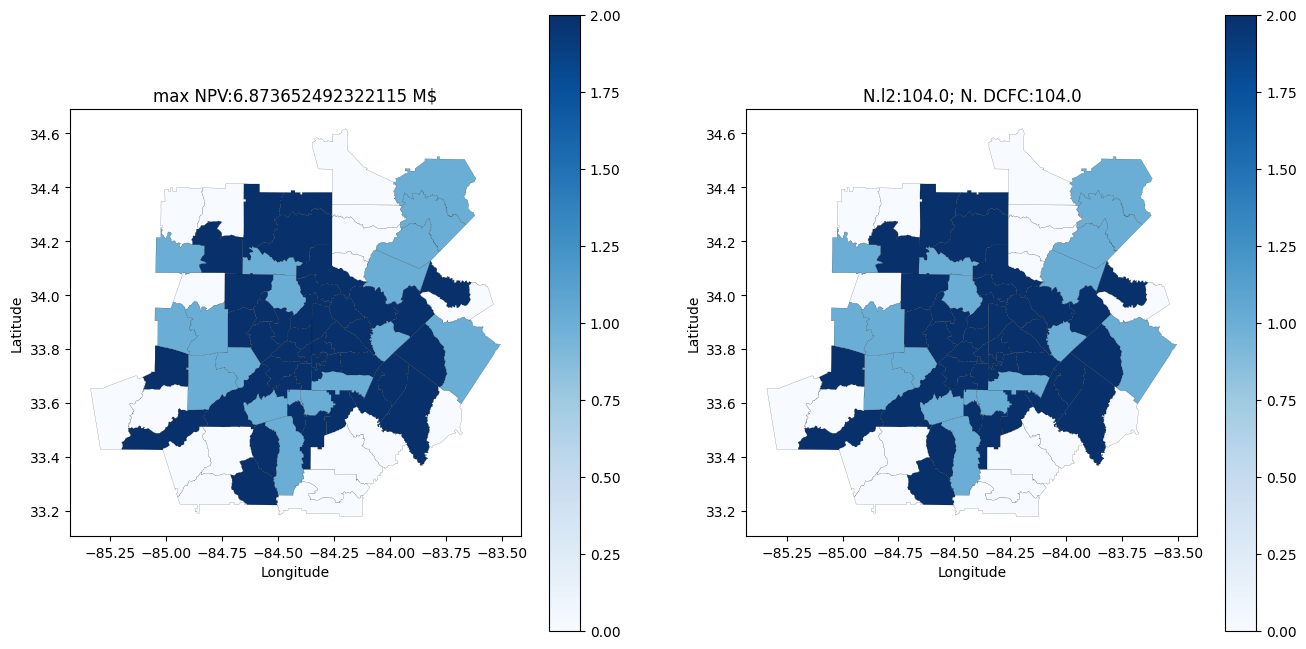

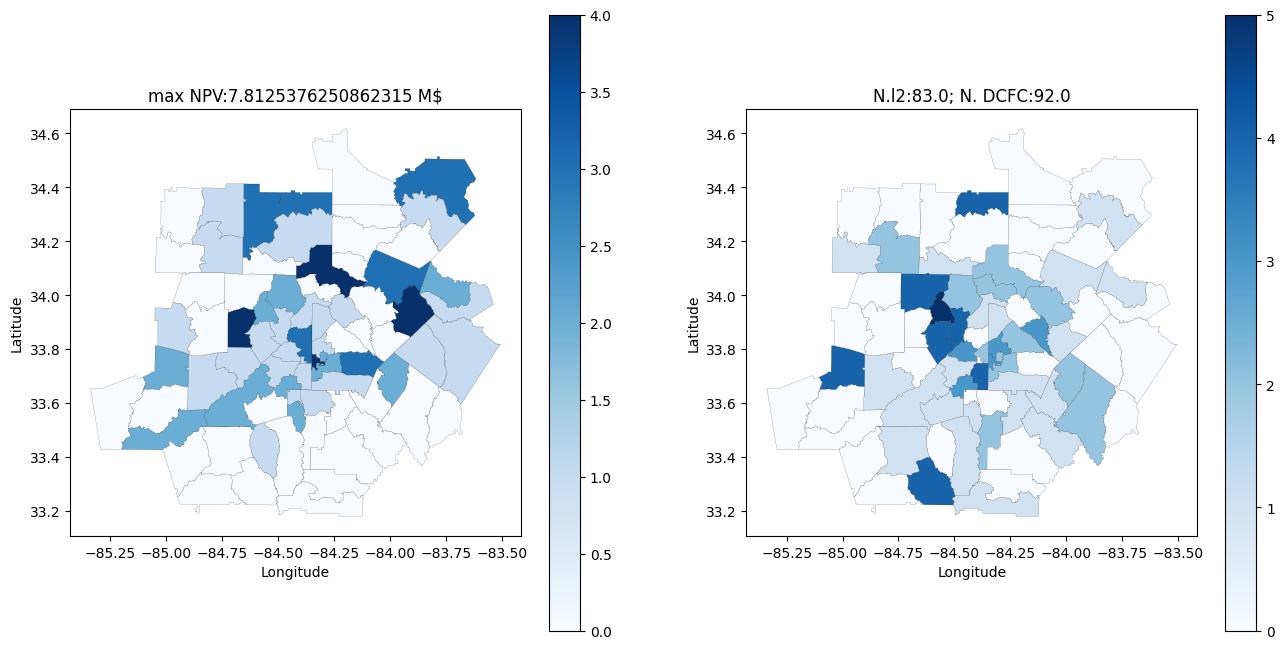

In [20]:
############# plot for REMBO (run only if used REMBO solver)

for i in range(len(best_observed_all)):
    which_trial = i
    result_x = best_observed_all_x[which_trial][len(best_observed_all_x[0])-1]
    result_x = torch.clamp(optimizationSolverModel.low_to_high_dimension(A_all[i],result_x), min=0, max=None) 
    result_x = torch.reshape(result_x,(2,optimizationSolverModel.trip.num_zone)).to(dtype = optimizationSolverModel.trip.ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_title('N.l2:%s; N. DCFC:%s'%(sum(result_x[0]),sum(result_x[1])))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')
